In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
######## Import Libraries ########
import numpy as np
from google.colab import files
import matplotlib.pyplot as plt 
import math, time, timeit, random

import tensorflow
from tensorflow.keras.optimizers import Adam
from keras.models import model_from_json
from keras import backend as K

In [ ]:
# download Dataset (structures of atoms)
id = ["1mF_xVxamS4MZenCP8Id9H47ec6F-Ykdz", 
      "14oZchc1LwooFdfx5FNdhSkmpb8Kk-tC-", 
      "1IFdIDwzFsQlYS6syLT3_KVu8tddAMYCq", 
      "1ZXgvH5dkm7XxeqdMjBOP4csHqFFqepaw",
      "1vmaP5B64_srduCChCNwxcH02Ks6JSNhc",
      "1kVtcJPS71dZXBLLjzSriwpI2MCnxLlxn",
      "1eRLHDsGU4FfQHko0OsX5fOgnxQrchvWP",
      "11rhWFFevWa94y9tZGj0D45c5DS0xzhcy",
      "1I2oFy-p8UfKJboVX9qTN876O3TKVoCDa"]
name = ['X_train', 'xyz_train', 'y_train', 'X_test', 'xyz_test', 'y_test', 'X_validation', 'xyz_val', 'y_validation']
for i in range(len(id)):
    download = drive.CreateFile({'id': id[i]})
    download.GetContentFile('{}.npy'.format(name[i]))


In [ ]:
# Load the model of Decoder and VAE for testing purposes
# Structure of the model has been saved as a .json file and weights have been saved as .h5
download = drive.CreateFile({'id':"1iwTXYOKpKQr4wk9aXATiRINNeDqJwTBt"})
download.GetContentFile('Decoder_Model.json')

download = drive.CreateFile({'id':"1ZcSgheWu1K3tmh88np21NoSthohzdAoU"})
download.GetContentFile('Decoder_Weights.h5')

download = drive.CreateFile({'id':"1gDmQNcj0iv1bQnnoMENijzLpVa7PMBpe"})
download.GetContentFile('VAE_Model0.json')

download = drive.CreateFile({'id':"1XbBcOhWfk4XMAnbVTSvfQmWgZKebY9QK"})
download.GetContentFile('VAE_Weights.h5')


In [ ]:
## Load dataset from colab memory
X_train = np.load("X_train.npy")
X_test = np.load("X_test.npy")
X_validation = np.load("X_validation.npy")

# Dataset Normalization (divide over maximum value of dataset)
X_train /= 5.7
X_test /= 5.7
X_validation /= 5.7

In [ ]:
# Load xyz dataset
xyz_train = np.load("xyz_train.npy")
xyz_test = np.load("xyz_test.npy")
xyz_val = np.load("xyz_val.npy")

In [ ]:
# Load Enrgies of each structure
y_train = np.load("y_train.npy")
y_test = np.load("y_test.npy")
y_validation = np.load("y_validation.npy")

In [ ]:
# Encoder
input_data = tensorflow.keras.layers.Input(shape = (216, 5), name='input_encoder')

encoder_conv1 = tensorflow.keras.layers.Conv1D(256, kernel_size = 3, padding='same')(input_data)
encoder_act1 = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(encoder_conv1)
#encoder = tensorflow.keras.layers.BatchNormalization()(encoder)

encoder_conv2 = tensorflow.keras.layers.Conv1D(128, kernel_size = 3, padding='same')(encoder_act1)
encoder_act2 = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(encoder_conv2)
#encoder = tensorflow.keras.layers.BatchNormalization()(encoder)

encoder_conv3 = tensorflow.keras.layers.Conv1D(64, kernel_size = 3, padding='same')(encoder_act2)
encoder_act3 = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(encoder_conv3)
#encoder = tensorflow.keras.layers.BatchNormalization()(encoder)

encoder_conv4 = tensorflow.keras.layers.Conv1D(32, kernel_size = 3, padding='same')(encoder_act3)
encoder_act4 = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(encoder_conv4)
#encoder = tensorflow.keras.layers.BatchNormalization()(encoder)

encoder_conv3 = tensorflow.keras.layers.Conv1D(1, kernel_size = 3, padding='same')(encoder_act4)
encoder = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(encoder_conv3)
#encoder = tensorflow.keras.layers.BatchNormalization()(encoder)

encoder_flatten = tensorflow.keras.layers.Flatten()(encoder)

def sample_latent_features(distribution):
    distribution_mean, distribution_variance = distribution
    batch_size = tensorflow.shape(distribution_variance)[0]
    random = tensorflow.keras.backend.random_normal(shape=(batch_size, tensorflow.shape(distribution_variance)[1]))
    return distribution_mean + tensorflow.exp(0.5 * distribution_variance) * random

distribution_mean = tensorflow.keras.layers.Dense(216, name='mean')(encoder_flatten)
distribution_variance = tensorflow.keras.layers.Dense(216, name='variance')(encoder_flatten)
latent_encoding = tensorflow.keras.layers.Lambda(sample_latent_features)([distribution_mean, distribution_variance])

encoder_model = tensorflow.keras.Model(input_data, latent_encoding)
encoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_encoder (InputLayer)      [(None, 216, 5)]     0                                            
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 216, 256)     4096        input_encoder[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_10 (LeakyReLU)      (None, 216, 256)     0           conv1d_10[0][0]                  
__________________________________________________________________________________________________
conv1d_11 (Conv1D)              (None, 216, 128)     98432       leaky_re_lu_10[0][0]             
____________________________________________________________________________________________

In [ ]:
decoder_input = tensorflow.keras.layers.Input(shape = (216), name='input_encoder')

decoder_dense1 = tensorflow.keras.layers.Dense(216)(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape((216, 1))(decoder_dense1)

decoder_conv1 = tensorflow.keras.layers.Conv1D(256, kernel_size = 3, padding='same')(decoder_reshape)
decoder_act1 = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(decoder_conv1)
#decoder = tensorflow.keras.layers.BatchNormalization()(decoder_act1)

decoder_conv2 = tensorflow.keras.layers.Conv1D(128, kernel_size = 3, padding='same')(decoder_act1)
decoder_act2 = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(decoder_conv2)
#decoder = tensorflow.keras.layers.BatchNormalization()(decoder)

decoder_conv3 = tensorflow.keras.layers.Conv1D(64, kernel_size = 3, padding='same')(decoder_act2)
decoder_act3 = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(decoder_conv3)
#decoder = tensorflow.keras.layers.BatchNormalization()(decoder)

decoder_conv4 = tensorflow.keras.layers.Conv1D(32, kernel_size = 3, padding='same')(decoder_act3)
decoder_act4 = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(decoder_conv4)
#decoder = tensorflow.keras.layers.BatchNormalization()(decoder)


decoder_output = tensorflow.keras.layers.Conv1D(3, kernel_size = 3, padding='same')(decoder_act4)

decoder_model = tensorflow.keras.Model(decoder_input, decoder_output)
decoder_model.summary()


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_encoder (InputLayer)   [(None, 216)]             0         
_________________________________________________________________
dense (Dense)                (None, 216)               46872     
_________________________________________________________________
reshape (Reshape)            (None, 216, 1)            0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 216, 256)          1024      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 216, 256)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 216, 128)          98432     
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 216, 128)          0   

In [ ]:
vae_input = tensorflow.keras.layers.Input(shape=(216,5), name="VAE_input")
encode = encoder_model(vae_input)
decode = decoder_model(encode)
vae = tensorflow.keras.Model(vae_input, decode)
vae.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VAE_input (InputLayer)       [(None, 216, 5)]          0         
_________________________________________________________________
model_2 (Functional)         (None, 216)               227185    
_________________________________________________________________
model_3 (Functional)         (None, 216, 3)            177435    
Total params: 404,620
Trainable params: 404,620
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_pred, y_true):
        reconstruction_loss = tensorflow.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tensorflow.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tensorflow.square(distribution_mean) - tensorflow.exp(distribution_variance)
        kl_loss_batch = tensorflow.reduce_mean(kl_loss)
        return kl_loss_batch * (-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_pred, y_true)
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance)
        return kl_loss_batch + reconstruction_loss_batch
    
    return total_loss


In [ ]:
vae.compile(loss='mse', optimizer= 'rmsprop' ) #get_loss(distribution_mean, distribution_variance) # Adam(learning_rate=0.0005, beta_1=0.5, beta_2=0.999, epsilon=1e-07)

In [ ]:
dis_input = tensorflow.keras.layers.Input(shape = (256), name='input_discriminator')

discriminator = tensorflow.keras.layers.Dense(512)(dis_input)
discriminator = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(discriminator)

discriminator = tensorflow.keras.layers.Dense(256)(discriminator)
discriminator = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(discriminator)

discriminator = tensorflow.keras.layers.Dense(128)(discriminator)
discriminator = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(discriminator)

discriminator = tensorflow.keras.layers.Dense(64)(discriminator)
discriminator = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(discriminator)

discriminator = tensorflow.keras.layers.Dense(32)(discriminator)
discriminator = tensorflow.keras.layers.LeakyReLU(alpha=0.1)(discriminator)

dis_output = tensorflow.keras.layers.Dense(1, activation='sigmoid')(discriminator)

discriminator_model = tensorflow.keras.Model(dis_input, dis_output)
discriminator_model.summary()

discriminator_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


Epoch 1/400
2188/2188 [==============================] - 28s 9ms/step - loss: 5.1225 - val_loss: 1.8324
Epoch 2/400
2188/2188 [==============================] - 19s 9ms/step - loss: 1.4160 - val_loss: 1.0641
Epoch 3/400
2188/2188 [==============================] - 19s 9ms/step - loss: 1.0122 - val_loss: 0.8500
Epoch 4/400
2188/2188 [==============================] - 19s 9ms/step - loss: 0.8632 - val_loss: 0.7498
Epoch 5/400
2188/2188 [==============================] - 19s 9ms/step - loss: 0.7580 - val_loss: 0.6709
Epoch 6/400
2188/2188 [==============================] - 19s 9ms/step - loss: 0.6800 - val_loss: 0.6376
Epoch 7/400
2188/2188 [==============================] - 19s 9ms/step - loss: 0.6292 - val_loss: 0.5972
Epoch 8/400
2188/2188 [==============================] - 20s 9ms/step - loss: 0.5778 - val_loss: 0.5724
Epoch 9/400
2188/2188 [==============================] - 20s 9ms/step - loss: 0.5505 - val_loss: 0.4918
Epoch 10/400
2188/2188 [==============================] - 20s 9m

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

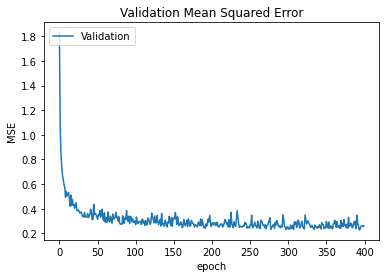

In [ ]:
history = vae.fit(X_train, xyz_train, epochs=400, batch_size=32, validation_data=(X_validation, xyz_val))

vae_json = vae.to_json()
decoder_json = decoder_model.to_json()

with open("VAE_Model_try71.json", "w") as json_file:
    json_file.write(vae_json)
with open("Decoder_Model_try71.json", "w") as json_file:
    json_file.write(decoder_json)

vae.save_weights("VAE_Weights_try71.h5")
decoder_model.save_weights("Decoder_Weights_try71.h5")

files.download("VAE_Weights_try71.h5")
files.download("VAE_Model_try71.json")

files.download("Decoder_Model_try71.json")
files.download("Decoder_Weights_try71.h5")

# summarize history for loss
fig = plt.figure()
#plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_loss'])
plt.title('Validation Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('epoch')
plt.legend(['Validation'], loc='upper left')
plt.show()

In [ ]:
# Load the trained model for testing purposes
# Just when you are not going to train the model right now

json_file = open('Decoder_Model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_decoder= model_from_json(loaded_model_json)
# load weights into new model
loaded_decoder.load_weights("Decoder_Weights.h5")
print("Loaded model from disk")

loaded_decoder.compile(loss='mse', optimizer='adam')

Loaded model from disk


In [ ]:
# Create a normal distribution and give it to the decoder as a generative network
random_noise=np.random.random((2,256))
prediction=loaded_decoder.predict(random_noise)

In [ ]:
# Save the generated structures in a csv file.
import csv
counter = 0
for i in range(prediction.shape[0]):
    with open(f'generated_structure{counter}.csv','w') as f1:
        writer=csv.writer(f1, delimiter='\t')
        num_rows = prediction[i].shape[0]
        for j in range(num_rows):
            row = prediction[i][j]
            writer.writerow(row)
    counter += 1